# Integer Program For Evacuation Without Vehicles Nor Stamina Ratings.
This script describes the distribution of miners between refuge chambers and shafts during a mine evacuation.
A CAD model from the Turqoise Ridge Mine (Nevada Gold Mines) was used for validating the model.
No vehicles nor stamina ratings were used for this evacuation.

***

## Import the required libraries.

In [1]:
import pandas as pd
import timeit
import math
import random
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

## Create a dataframe from the airlines(drifts) .xlsx file.
The .xlsx file was obtained by extracting the drift coordinates from the CAD file of the mine. The drifts are referred to as **'airlines'** in the CAD model.

In [2]:
drifts = pd.read_excel("airlines.xlsx")

## Visualize the layout of the TR Mine in 3-dimensions.
The mine has two shafts serving as the main source of egress. The mine extends multiple levels spanning several kilometers.

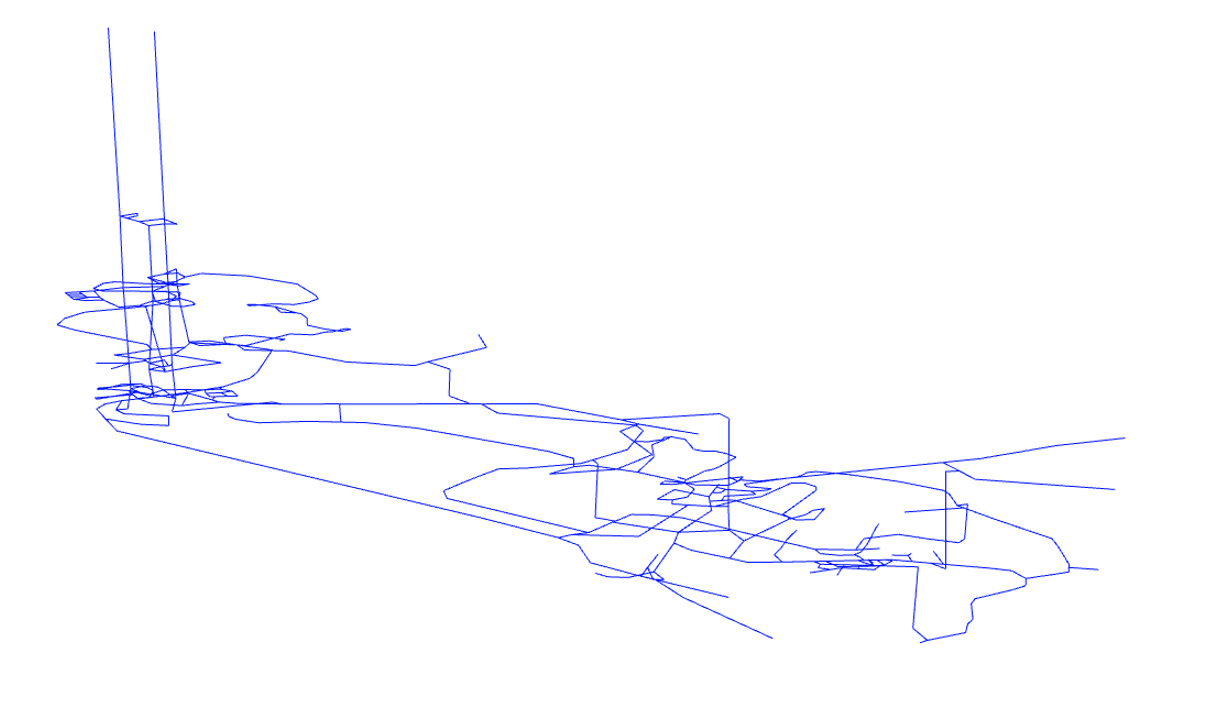

## Start the timer.
The timer is used to check the elapsed time from the creation of the model components to the final output.

In [3]:
start = timeit.default_timer()

## Extract the nodes within the mine network.
The drift nodes represent transhipment nodes. Other node types are specified later.

In [4]:
def define_nodes(lines):
    #make a list of the vertices in the network of drifts.
    X = []
    Y = []
    Z = []
    
    #add all starting vertices to list.
    for i in range(len(lines)):
         if lines.iloc[i]['x1'] not in X or lines.iloc[i]['y1'] not in Y or lines.iloc[i]['z1'] not in Z:
            X.append(lines.iloc[i]['x1'])
            Y.append(lines.iloc[i]['y1']) 
            Z.append(lines.iloc[i]['z1'])
    
    #add the ending vertices that do not connect two edges.
    for i in range(len(lines)):
        if lines.iloc[i]['x2'] not in X or lines.iloc[i]['y2'] not in Y or lines.iloc[i]['z2'] not in Z:
            X.append(lines.iloc[i]['x2'])
            Y.append(lines.iloc[i]['y2'])
            Z.append(lines.iloc[i]['z2'])
    
    #add all coordinates to one list.
    coords = []
    for i in range(len(X)):
        coords.append([X[i],Y[i],Z[i]])
        
    return coords

In [5]:
nodes = define_nodes(drifts)

## Extract the edges within the mine network.
The edges join two nodes together to form the drift. These edges are extracted from the CAD model edges.

In [6]:
def define_edges(lines):
    df_nodes = pd.DataFrame(nodes)
    x1 = []
    x2 = []
    node_combinations_temp = []
    node_combinations =[]
    
    #Check the start coordinates and their location in the list of drift nodes.
    for i in range(len(lines)):
        g = lines['x1'][i] == df_nodes[0]
        h = lines['y1'][i] == df_nodes[1]
        k = lines['z1'][i] == df_nodes[2]
        gl = list(g)
        hl = list(h)
        kl = list(k)
        for j in range(len(gl)):
            if gl[j] == True and hl[j] == True and kl[j] == True:
                x1.append(j)
    
    #Check the end coordinates and their location in the nodes list
    for i in range(len(lines)):
        g = lines['x2'][i] == df_nodes[0]
        h = lines['y2'][i] == df_nodes[1]
        k = lines['z2'][i] == df_nodes[2]
        gl = list(g)
        hl = list(h)
        kl = list(k)
        for j in range(len(gl)):
            if gl[j] == True and hl[j] == True and kl[j] == True:
                x2.append(j)
    
    #Add the start and end nodes to one list           
    for i in range(len(x1)):
        node_combinations_temp.append([x1[i], x2[i]])
        
    #Set reverse for hallways    
    for i in node_combinations_temp:
        node_combinations.append([i[0], i[1]])
        node_combinations.append([i[1], i[0]])
    
    
    return node_combinations

In [7]:
edges = define_edges(drifts)

## Calculate the distances between nodes.
The edge lengths are calculated and subsequently used to find the edge weights for the model.

In [8]:
def distances():
    #Calculate the distances between the start and end nodes.
    for i in edges:
        dist = ((nodes[i[0]][0] - nodes[i[1]][0])**2 + (nodes[i[0]][1] - nodes[i[1]][1])**2 + (nodes[i[0]][2] - nodes[i[1]][2])**2)**0.5
        i.append(dist)
    
    return edges

In [9]:
dist = distances()

## Calculate the slopes between nodes.
Since the nodes are not on the same elevation within a mine, The slopes need to be calculated to correct for the distances between nodes.

In [10]:
#Calculate the slope from one point to another
def slopes():
        
    
    #Caluclate distances and radius of the path
    for i in dist:
        XtoY = ((nodes[i[0]][0] - nodes[i[1]][0])**2 + (nodes[i[0]][1] - nodes[i[1]][1])**2)**0.5
        Z = abs(nodes[i[0]][2] - nodes[i[1]][2])
        rad =  math.degrees(math.atan(Z/XtoY))
        i.append(rad)
        
    return dist

In [11]:
slope = slopes()

## Adjust the edge lengths for slope.
The edge lengths are adjusted depending on the slope (inclination) of the edges.

In [12]:
#Adjust path length for slope 
for i in edges:
    if nodes[i[1]][2] > nodes[i[0]][2] and i[3] < 80:
        x = (80*9.81*5*(math.sin(math.radians(i[3]))))/200 + math.cos(math.radians(i[3]))
        i[2] = i[2]*x

In [13]:
#Create list of final distances to use in optimization
final_distances = []
for i in edges:
    final_distances.append([i[0], i[1], i[2]])

## Randomly distribute miners within the mine.
Miners are distributed randomly within the confines of the mine network. The **'random.seed'** is used for this purpose. The number of miners can be altered by the user.

In [14]:
#Create individuals and their locations
random.seed(9002)
ind = 300 #Number of individuals in the mine
location = [] #empty list for locations in mine

#create random location for all individuals
for i in range(ind):
    location.append(random.choice(edges))

random.seed(9002)
#location of miner at selected path 
partial = []
for i in range(ind):
    partial.append(random.uniform(0, 1))

## Create temporary edges and nodes.
Temporary edges are created to connect each miner to the drift network. The edge connects a miner to the node preceeding him/her and the next node.

In [15]:
#make temporary edges and nodes
temp_edges = []
for i in range(len(location)):
    temp_edges.append([(len(nodes)+i), location[i][0], (location[i][2]*partial[i])])
    temp_edges.append([(len(nodes)+i), location[i][1], (location[i][2]*(1-partial[i]))])

In [16]:
# Calculate coordinates of temporary nodes
miners = []
for i in range(len(location)):
    temp = [0]*3
    
    #x-axis
    if nodes[location[i][0]][0] < nodes[location[i][1]][0]:
        temp[0] = nodes[location[i][0]][0] + partial[i]*abs((nodes[location[i][1]][0]-nodes[location[i][0]][0]))
        
    if nodes[location[i][0]][0] == nodes[location[i][1]][0]:
        temp[0] = nodes[location[i][0]][0]
        
    if nodes[location[i][0]][0] > nodes[location[i][1]][0]:
        temp[0] = nodes[location[i][0]][0] - partial[i]*abs((nodes[location[i][1]][0]-nodes[location[i][0]][0]))
        
    #y-axis
    if nodes[location[i][0]][1] < nodes[location[i][1]][1]:
        temp[1] = nodes[location[i][0]][1] + partial[i]*abs((nodes[location[i][1]][1]-nodes[location[i][0]][1]))
        
    if nodes[location[i][0]][1] == nodes[location[i][1]][1]:
        temp[1] = nodes[location[i][0]][1]
        
    if nodes[location[i][0]][1] > nodes[location[i][1]][1]:
        temp[1] = nodes[location[i][0]][1] - partial[i]*abs((nodes[location[i][1]][1]-nodes[location[i][0]][1]))
    
    #z-axis
    if nodes[location[i][0]][2] < nodes[location[i][1]][2]:
        temp[2] = nodes[location[i][0]][2] + partial[i]*abs((nodes[location[i][1]][2]-nodes[location[i][0]][2]))
        
    if nodes[location[i][0]][2] == nodes[location[i][1]][2]:
        temp[2] = nodes[location[i][0]][2]
        
    if nodes[location[i][0]][2] > nodes[location[i][1]][2]:
        temp[2] = nodes[location[i][0]][2] - partial[i]*abs((nodes[location[i][1]][2]-nodes[location[i][0]][2]))
        
    nodes.append(temp)
    miners.append(temp)

## Create fire emergency at a random location within the mine.
A fire is set at a random location to simulate a mine emergency. Edges that surround the region of the fire emergency are removed from the network to prevent miners from accessing these areas.

In [17]:
#Create fire at random location(s) and remove edges from network
random.seed(9002)
num_fires = 1
loc_fire = []
for x in range(num_fires):
    loc_fire.append(random.choice(final_distances))

for i in loc_fire:
    for j in final_distances:
        if i[0] == j[0] and i[1] == j[1]:
            final_distances.remove(j)
for i in loc_fire:
    for j in final_distances:            
        if i[0] == j[1] and i[1] == j[0]:
            final_distances.remove(j)

In [18]:
#add temporary edges to final distances list
for i in temp_edges:
    final_distances.append(i)

## Calculate the travel times along edges.
The time it takes for miners to traverse an edge is dependent on the length of the edge and the walking speed. The average walking speed is assumed to be $1.35$ m/s. This speed can be altered by the user.

In [19]:
# Calculate the travel time along the edges if all the miners evacuate by foot
foot_time = []
walking_speed = 1.35    # Average walking speed in m/s.
for i in final_distances:
    corrf = i[2] / walking_speed
    foot_time.append([i[0], i[1], corrf])

In [20]:
nodes_dict = {}
for i in range(len(nodes)):
    nodes_dict[i] = nodes[i]

## Extract the origin nodes.
The origin nodes represent the locations of miners within the mine network. Number ID's are used to represent each miner.

In [21]:
origins = []
for node in nodes_dict:
    for miner in miners:
        if nodes_dict[node] == miner:
            origins.append(node)

## Define the locations of the shafts and refuge chambers.
The locations of the shaft accesses and refuge chambers were extracted from the nodes data. There are **four** accesses to the two shafts and **four** refuge chambers were set up such that there is a refuge chamber within a $30$ min walk from each miner according to NIOSH safety regulations.

In [22]:
shafts = [28, 69, 73, 74]
chambers =  [156, 198, 305, 348]
destinations = shafts + chambers

## Visualize the location of the shafts and refuge chambers.
The yellow points represent nodes at which the miners can access the shafts. The orange points represent the locations of the refuge chambers.

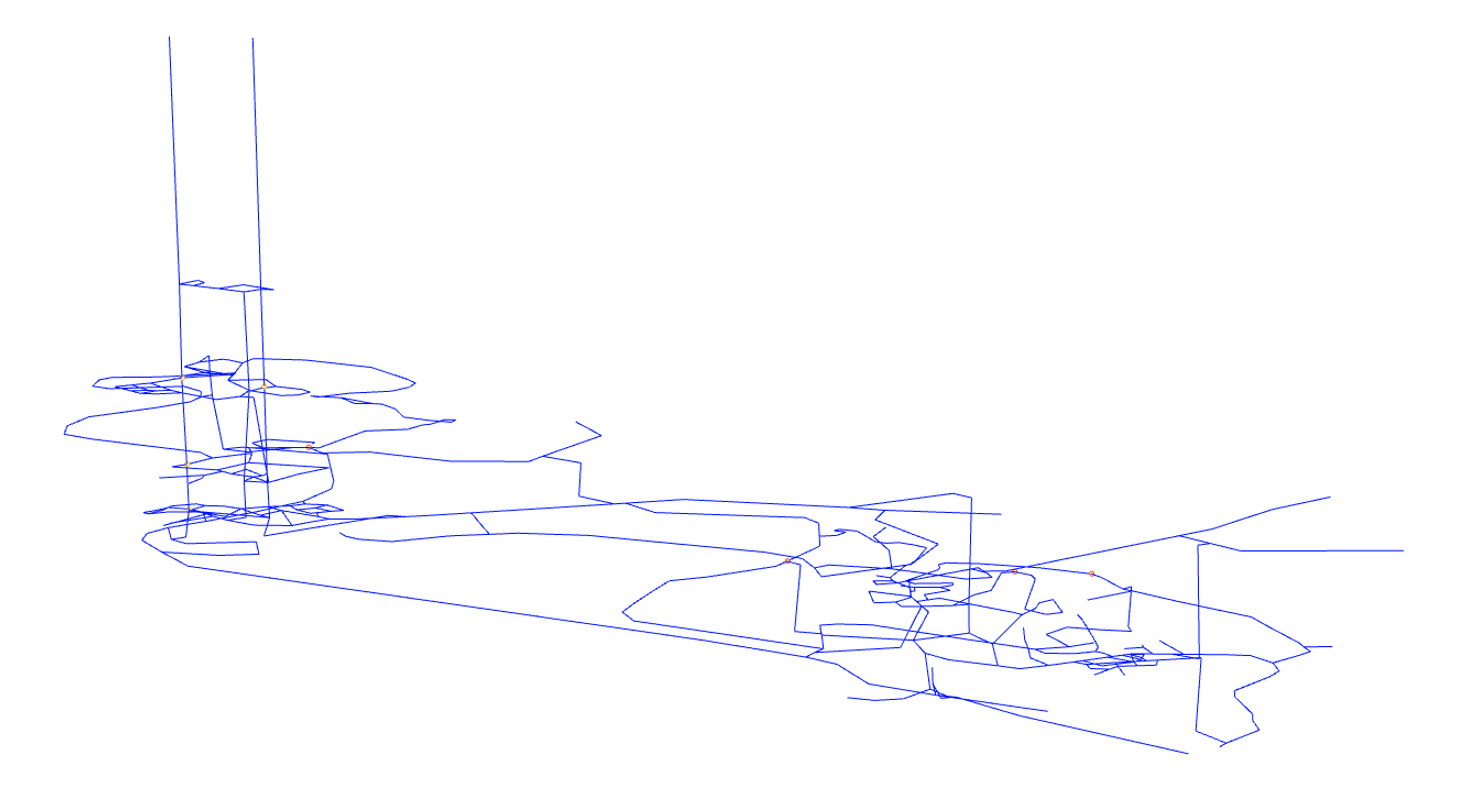

## Generate the data for the model.
The data required for the model is generated at this stage.

In [23]:
nodes_list = []
for node in range(len(nodes)):
    nodes_list.append(node)

In [24]:
arcs = []
for item in foot_time:
    arcs.append((item[0], item[1]))

In [25]:
cost = {}
for item in foot_time:
    key = (item[0], item[1])
    value = item[2]
    cost[key] = value

### Set the net demand and capacities.
The net demand at each node is set here. Origin nodes, where miners are located, have a net demand of **-1**. The shafts have infinite capacity, so a value of **1000** is used. The refuge chambers have a capacity of **30** people each. This capacity was chosen in line with MineArc's Cost Effective Refuge-Chamber MineSAFE Essential Design specifications.

In [26]:
net_demand = {}
for node in nodes_list:
    if node in origins:
        net_demand[node] = -1
    elif node in shafts:
        net_demand[node] = 1000
    elif node in chambers:
        net_demand[node] = 30
    else:
        net_demand[node] = 0

## Construct the model.
The model is constructed at this stage. A concretemodel is defined for the TR Mine using the data collected. The **'gurobi'** solver was used to solve the model. Other solvers can be used by the user.

In [27]:
# Construct the model
model = pyo.ConcreteModel()

In [28]:
# Set up the solver
solver = SolverFactory('gurobi') 

In [29]:
# Sets
model.ORIGINS = pyo.Set(initialize=origins)
model.DESTINATIONS = pyo.Set(initialize=destinations)
model.NODES = pyo.Set(initialize=nodes_list)
model.ARCS = pyo.Set(initialize=arcs)

In [30]:
# Parameters
model.netDemand = pyo.Param(model.NODES, initialize=net_demand)
model.cost = pyo.Param(model.ARCS, initialize=cost)

In [31]:
# Decision variables
model.x = pyo.Var(model.ARCS, domain=pyo.NonNegativeIntegers)

The objective function is as follows:

$$\min \sum_{(i, j) \in ARCS} cost_{ij} \times x_{ij}$$

The objective of the model is to minimize the total cost of transporting all the miners to the safe areas during evacuation.

In [32]:
# Construct the objective function
def objective_rule(model):
    return sum(model.cost[i, j] * model.x[i, j] for (i, j) in model.ARCS)
model.Obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

The net demand and capacity constraints are as follows:

$$\sum_{(k,i) \in ARCS} x_{ki} - \sum_{(i,j) \in ARCS} x_{ij} = netdemand_{ij} \: \forall i \in NODES$$

This constraint ensures the conservation of flow within the mine network. The shafts and refuge chambers make use of **'<='** in place of the **=** sign.

In [33]:
# Define the model constraints
# Net demand constraint
def net_demand_rule(model, i):
    if i in shafts or i in chambers:
        return (sum(model.x[k, i] for k in model.NODES if (k, i) in model.ARCS) - sum(model.x[i, j] for j in model.NODES if (i, j) in model.ARCS) <= model.netDemand[i])
    else:
        return (sum(model.x[k, i] for k in model.NODES if (k, i) in model.ARCS) - sum(model.x[i, j] for j in model.NODES if (i, j) in model.ARCS) == model.netDemand[i])
model.netDemandConstraints = pyo.Constraint(model.NODES, rule=net_demand_rule)

## Solve the model.
The model is solved using the **gurobi** solver via Pyomo's Solverfactory.

In [34]:
result = solver.solve(model, tee=True)

Using license file C:\Users\fasare\gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file C:\Users\fasare\AppData\Local\Temp\tmp2xntpj1p.pyomo.lp
Reading time = 0.01 seconds
x1643: 754 rows, 1643 columns, 3285 nonzeros
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 754 rows, 1643 columns and 3285 nonzeros
Model fingerprint: 0x66386498
Variable types: 1 continuous, 1642 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 457 rows and 687 columns
Presolve time: 0.00s
Presolved: 297 rows, 956 columns, 1912 nonzeros
Variable types: 0 continuous, 956 integer (228 binary)

Root relaxation: objective 6.227430e+05, 604 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Ti

<div class="alert alert-block alert-success">
    <b>Success</b>: The model was feasible and returned an optimal solution.
</div>

In [35]:
stop = timeit.default_timer()
print('Time: ', stop - start) 

Time:  2.134070799977053


## Extract the optimal values.
The optimal values are extracted from the solved model and a table of results is shown below. The model was run for **three** differenct scenarios. The first scenario has **100** miners, which represent a night shift within the mine where the least number of people are underground. The second scenario has **200** miners, representing the average number of people underground during a regular morning shift at the mine. The final scenario has **300** people underground, representing a morning shift in which there are visitors at the mine such as college students.

The distribution of miners to the shafts and refuge chambers for each scenario are shown in the table below:

|  Safe Zone  | 100 Miners | 200 Miners | 300 Miners |
| ----------- | ---------- | ---------- | ---------- |
|  Shaft 28   |     15     |     30     |     113    |
|  Shaft 69   |      9     |     22     |      29    |
|  Shaft 73   |      6     |     12     |      16    |
|  Shaft 74   |     11     |     17     |      22    |
| Chamber 156 |     16     |     30     |      30    |
| Chamber 198 |      6     |     29     |      30    |
| Chamber 305 |     20     |     30     |      30    |
| Chamber 348 |     17     |     30     |      30    |

In [36]:
# Check how many miners were sent to each safe zone
# shaft 28
shaft_28 = []
for arc in model.ARCS:
    if arc[1] == 28:
        shaft_28.append(pyo.value(model.x[arc]))
        
total_shaft_28 = sum(shaft_28)

# Shaft 69
shaft_69 = []
for arc in model.ARCS:
    if arc[1] == 69:
        shaft_69.append(pyo.value(model.x[arc]))
        
total_shaft_69 = sum(shaft_69)

#Shaft 73
shaft_73 = []
for arc in model.ARCS:
    if arc[1] == 73:
        shaft_73.append(pyo.value(model.x[arc]))
        
total_shaft_73 = sum(shaft_73)

#Shaft 74
shaft_74 = []
for arc in model.ARCS:
    if arc[1] == 74:
        shaft_74.append(pyo.value(model.x[arc]))
        
total_shaft_74 = sum(shaft_74)

In [37]:
#Chamber 156
chamber_156 = []
for arc in model.ARCS:
    if arc[1] == 156:
        chamber_156.append(pyo.value(model.x[arc]))
        
total_chamber_156 = sum(chamber_156)

#Chamber 198
chamber_198 = []
for arc in model.ARCS:
    if arc[1] == 198:
        chamber_198.append(pyo.value(model.x[arc]))
        
total_chamber_198 = sum(chamber_198)

#Chamber 305
chamber_305 = []
for arc in model.ARCS:
    if arc[1] == 305:
        chamber_305.append(pyo.value(model.x[arc]))
        
total_chamber_305 = sum(chamber_305)

#Chamber 348
chamber_348 = []
for arc in model.ARCS:
    if arc[1] == 348:
        chamber_348.append(pyo.value(model.x[arc]))
        
total_chamber_348 = sum(chamber_348)